In [1]:
#import sklearn.ensemble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import save
from numpy import load
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import joblib
from sklearn.metrics import mean_squared_error
import seaborn as sns
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
import kerastuner as kt
import scipy

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

### Load Data

In [4]:
with open ('../data/lstm_mlp/label_keys', 'rb') as fp:
    label_keys = pickle.load(fp)
with open ('../data/lstm_mlp/feature_keys', 'rb') as fp:
    feature_keys = pickle.load(fp)    


train_unsc = pd.read_pickle("../data/lstm_mlp/train_unsc_ts.pkl")
valid_unsc = pd.read_pickle("../data/lstm_mlp/valid_unsc_ts.pkl")
test_unsc = pd.read_pickle("../data/lstm_mlp/test_unsc_ts.pkl")
all_train_unsc = pd.read_pickle("../data/lstm_mlp/all_train_unsc_ts.pkl")

scaler_x = joblib.load("../data/lstm_mlp/scaler_all_train_x.save") 
scaler_y = joblib.load("../data/lstm_mlp/scaler_all_train_y.save") 

scaler_train_x = joblib.load("../data/lstm_mlp/scaler_train_valid_x.save") 
scaler_train_y = joblib.load("../data/lstm_mlp/scaler_train_valid_y.save")

train_norm = pd.read_pickle("../data/lstm_mlp/train_scaled.pkl")
valid_norm = pd.read_pickle("../data/lstm_mlp/valid_scaled.pkl")
test_norm = pd.read_pickle("../data/lstm_mlp/test_scaled.pkl")
all_train_norm = pd.read_pickle("../data/lstm_mlp/all_train_scaled.pkl")

train_x = load('../data/lstm_mlp/train_x_norm.npy')
train_y = load('../data/lstm_mlp/train_y_norm.npy')
valid_x = load('../data/lstm_mlp/valid_x_norm.npy')
valid_y = load('../data/lstm_mlp/valid_y_norm.npy')
test_x = load('../data/lstm_mlp/test_x_norm.npy')
test_y = load('../data/lstm_mlp/test_y_norm.npy')
all_train_x = load('../data/lstm_mlp/all_train_x_norm.npy')
all_train_y = load('../data/lstm_mlp/all_train_y_norm.npy')

## Loop function

In [5]:
def test_5_times(model, epochs, batch_size):
    runs = 5
    test_score = list()
    train_score = list()
 
    for i in range(runs):

        np.random.seed(42 + i)
        tf.random.set_seed(42 + i)



        history = model.fit(all_train_x, all_train_y,
                        epochs=epochs,
                        batch_size=batch_size,
                       )

        y_pred_test = model.predict(test_x)
        y_test_unsc = scaler_y.inverse_transform(test_y)
        y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

        y_pred_train = model.predict(train_x)
        y_train_unsc = scaler_y.inverse_transform(train_y)
        y_pred_train_unsc = scaler_y.inverse_transform(y_pred_train)
        
        mse_test = np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  
        test_score.append(mse_test)

        mse_train = np.sqrt(mean_squared_error(y_pred_train_unsc, y_train_unsc))  
        train_score.append(mse_train)

    return  train_score, test_score


## Simple LSTM

In [6]:
def build_simple_lstm():
    LSTMSimple_model = keras.models.Sequential([
    keras.layers.LSTM(32,
                      input_shape=(all_train_x.shape[1],all_train_x.shape[2]),
                      return_sequences=False),
    
    keras.layers.Dense(2, kernel_initializer='he_normal', activation='relu')
    ])

    LSTMSimple_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))
    LSTMSimple_model.summary()
    
    return LSTMSimple_model

### Training

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

LSTMSimple_model = build_simple_lstm()
LSTMSimple_model_history = LSTMSimple_model.fit(train_x, train_y,
                    epochs=100,
                    batch_size=128, 
                    validation_data=(valid_x, valid_y),
                    callbacks=[ callback],
                    verbose=2
                   )             

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                7936      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 8,002
Trainable params: 8,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 - 2s - loss: 0.5306 - val_loss: 0.5289
Epoch 2/100
1/1 - 0s - loss: 0.5289 - val_loss: 0.5260
Epoch 3/100
1/1 - 0s - loss: 0.5260 - val_loss: 0.5165
Epoch 4/100
1/1 - 0s - loss: 0.5165 - val_loss: 0.5005
Epoch 5/100
1/1 - 0s - loss: 0.5005 - val_loss: 0.4788
Epoch 6/100
1/1 - 0s - loss: 0.4788 - val_loss: 0.4580
Epoch 7/100
1/1 - 0s - loss: 0.4580 - val_loss: 0.4406
Epoch 8/100
1/1 - 0s - loss: 0.4406 - val_loss: 0.4271
Epoch 9/100
1/1 - 0s - loss: 0.4271 - val_loss: 0.4171
Epoch 10/100
1/1 - 0s

In [8]:
y_pred_train= LSTMSimple_model.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_pred_train_unsc, y_train_unsc))  

22.153030827379038

In [9]:
y_pred_valid= LSTMSimple_model.predict(valid_x)
y_valid_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_valid_unsc = scaler_train_y.inverse_transform(y_pred_valid)

np.sqrt(mean_squared_error(y_pred_valid_unsc, y_valid_unsc))  

22.1530308475986

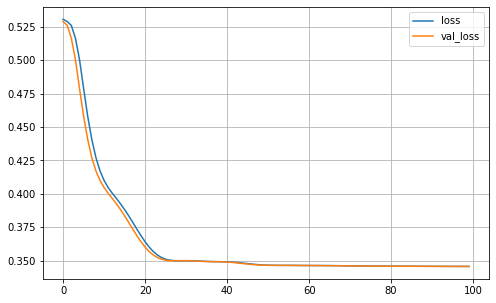

In [10]:
pd.DataFrame(LSTMSimple_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [11]:
hist_LSTMSimple_model_history = pd.DataFrame(LSTMSimple_model_history.history) 
# hist_LSTMSimple_model_history.to_pickle("../data/lstm_mlp/lstm_models/hist_LSTMSimple_model_history.pkl")

## Testing

In [12]:
LSTMSimple_model = build_simple_lstm()
LSTMSimple_model_history = LSTMSimple_model.fit(all_train_x, all_train_y,
                    epochs=75,
                    batch_size=128, 
                    verbose=2
                   )             

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                7936      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 8,002
Trainable params: 8,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
1/1 - 2s - loss: 0.2710
Epoch 2/75
1/1 - 0s - loss: 0.2402
Epoch 3/75
1/1 - 0s - loss: 0.2115
Epoch 4/75
1/1 - 0s - loss: 0.1843
Epoch 5/75
1/1 - 0s - loss: 0.1577
Epoch 6/75
1/1 - 0s - loss: 0.1331
Epoch 7/75
1/1 - 0s - loss: 0.1119
Epoch 8/75
1/1 - 0s - loss: 0.0942
Epoch 9/75
1/1 - 0s - loss: 0.0799
Epoch 10/75
1/1 - 0s - loss: 0.0686
Epoch 11/75
1/1 - 0s - loss: 0.0600
Epoch 12/75
1/1 - 0s - loss: 0.0534
Epoch 13/75
1/1 - 0s - loss: 0.0484
Epoch 14/75
1/1 - 0s - loss: 0.0444
Epoch 15/75
1/1 - 0

In [13]:
y_pred_test= LSTMSimple_model.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)
np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  

1.717846415614691

## Test 5 times

In [14]:
LSTMSimple_model = build_simple_lstm()
epochs = 75
batch_size = 128
train_score, test_score = test_5_times(LSTMSimple_model, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                7936      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 8,002
Trainable params: 8,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
1/1 [==============================] - 2s 2s/step - loss: 0.3552
Epoch 2/75
1/1 [==============================] - 0s 5ms/step - loss: 0.3263
Epoch 3/75
1/1 [==============================] - 0s 5ms/step - loss: 0.2989
Epoch 4/75
1/1 [==============================] - 0s 5ms/step - loss: 0.2752
Epoch 5/75
1/1 [==============================] - 0s 4ms/step - loss: 0.2554
Epoch 6/75
1/1 [==============================] - 0s 4ms/step - loss: 0.2394
Epoch 7/75
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 4ms/step - loss: 0.1874
Epoch 24/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1873
Epoch 25/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1873
Epoch 26/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1873
Epoch 27/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1873
Epoch 28/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1873
Epoch 29/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1873
Epoch 30/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1873
Epoch 31/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1872
Epoch 32/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1872
Epoch 33/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1872
Epoch 34/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1872
Epoch 35/75
1/1 [==============================] - 0s 3ms/step - loss: 0.187

1/1 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 54/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 55/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1865
Epoch 56/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 57/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1865
Epoch 58/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 59/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1865
Epoch 60/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1865
Epoch 61/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1865
Epoch 62/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 63/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 64/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 65/75
1/1 [==============================] - 0s 4ms/step - loss: 0.186

1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 9/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 10/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 11/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 12/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 13/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 14/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 15/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1863
Epoch 16/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 17/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 18/75
1/1 [==============================] - 0s 3ms/step - loss: 0.1863
Epoch 19/75
1/1 [==============================] - 0s 4ms/step - loss: 0.1863
Epoch 20/75
1/1 [==============================] - 0s 5ms/step - loss: 0.1863

In [15]:
pd.DataFrame(train_score).describe()

,0
count,5.000000
mean,11.908171
std,0.037505
min,11.879745
25%,11.883781
50%,11.892801
75%,11.913429
max,11.971098


In [16]:
pd.DataFrame(test_score).describe()

,0
count,5.000000
mean,11.908171
std,0.037505
min,11.879745
25%,11.883781
50%,11.892801
75%,11.913429
max,11.971098


## Simple LSTM with Dropout

In [17]:
Simple_Dropout_model = keras.models.Sequential([
        keras.layers.LSTM(16,
                          input_shape=(all_train_x.shape[1],all_train_x.shape[2]),
                          return_sequences=False,
                          dropout=0.2,
                          recurrent_dropout=0.2,
                          ),
        keras.layers.Dense(2, kernel_initializer='he_normal', activation='relu'),
    ])

Simple_Dropout_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))
Simple_Dropout_model.summary()
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

Simple_Dropout_model_history = Simple_Dropout_model.fit(train_x, train_y,
                    epochs=200,
                    batch_size=128, 
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback,],
                    verbose=2
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                2944      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 2,978
Trainable params: 2,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 - 3s - loss: 0.2303 - val_loss: 0.1962
Epoch 2/200
1/1 - 0s - loss: 0.2080 - val_loss: 0.1762
Epoch 3/200
1/1 - 0s - loss: 0.1858 - val_loss: 0.1577
Epoch 4/200
1/1 - 0s - loss: 0.1669 - val_loss: 0.1408
Epoch 5/200
1/1 - 0s - loss: 0.1479 - val_loss: 0.1253
Epoch 6/200
1/1 - 0s - loss: 0.1424 - val_loss: 0.1113
Epoch 7/200
1/1 - 0s - loss: 0.1155 - val_loss: 0.0988
Epoch 8/200
1/1 - 0s - loss: 0.1092 - val_loss: 0.0878
Epoch 9/200
1/1 - 0s - loss: 0.0996 - val_loss: 0.0782
Epoch 10/200
1/1 - 

Epoch 136/200
1/1 - 0s - loss: 0.0053 - val_loss: 0.0029
Epoch 137/200
1/1 - 0s - loss: 0.0066 - val_loss: 0.0028
Epoch 138/200
1/1 - 0s - loss: 0.0080 - val_loss: 0.0028
Epoch 139/200
1/1 - 0s - loss: 0.0070 - val_loss: 0.0027
Epoch 140/200
1/1 - 0s - loss: 0.0074 - val_loss: 0.0027
Epoch 141/200
1/1 - 0s - loss: 0.0070 - val_loss: 0.0027
Epoch 142/200
1/1 - 0s - loss: 0.0068 - val_loss: 0.0026
Epoch 143/200
1/1 - 0s - loss: 0.0077 - val_loss: 0.0026
Epoch 144/200
1/1 - 0s - loss: 0.0062 - val_loss: 0.0026
Epoch 145/200
1/1 - 0s - loss: 0.0064 - val_loss: 0.0025
Epoch 146/200
1/1 - 0s - loss: 0.0059 - val_loss: 0.0025
Epoch 147/200
1/1 - 0s - loss: 0.0066 - val_loss: 0.0025
Epoch 148/200
1/1 - 0s - loss: 0.0055 - val_loss: 0.0025
Epoch 149/200
1/1 - 0s - loss: 0.0062 - val_loss: 0.0025
Epoch 150/200
1/1 - 0s - loss: 0.0065 - val_loss: 0.0025
Epoch 151/200
1/1 - 0s - loss: 0.0055 - val_loss: 0.0024
Epoch 152/200
1/1 - 0s - loss: 0.0069 - val_loss: 0.0024
Epoch 153/200
1/1 - 0s - loss: 

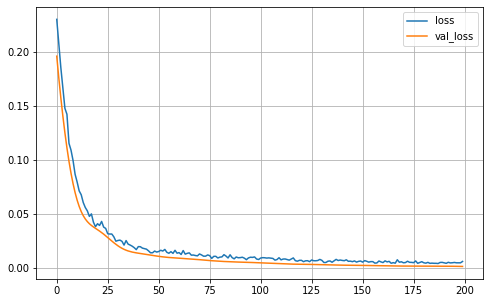

In [18]:
pd.DataFrame(Simple_Dropout_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [19]:
hist_Simple_Dropout_model_history = pd.DataFrame(Simple_Dropout_model_history.history) 
# hist_Simple_Dropout_model_history.to_pickle("../data/lstm_mlp/lstm_models/hist_Simple_Dropout_model_history.pkl")

## Simple LSTM with Weight Regularization

In [20]:
Simple_Weight_model = keras.models.Sequential([
        keras.layers.LSTM(16,
                          input_shape=(all_train_x.shape[1],all_train_x.shape[2]),
                          return_sequences=False,
                          dropout=0.2,
                          recurrent_dropout=0.2,
                          ),
        keras.layers.Dense(2, kernel_initializer='he_normal', activation='relu'),
    ])

Simple_Weight_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))
Simple_Weight_model.summary()
    
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

Simple_Weight_model_history = Simple_Weight_model.fit(train_x, train_y,
                    epochs=500,
                    batch_size=128, 
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback,],
                    verbose=2
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16)                2944      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 2,978
Trainable params: 2,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 - 3s - loss: 0.4293 - val_loss: 0.4113
Epoch 2/500
1/1 - 0s - loss: 0.4113 - val_loss: 0.3850
Epoch 3/500
1/1 - 0s - loss: 0.3866 - val_loss: 0.3542
Epoch 4/500
1/1 - 0s - loss: 0.3532 - val_loss: 0.3244
Epoch 5/500
1/1 - 0s - loss: 0.3276 - val_loss: 0.2959
Epoch 6/500
1/1 - 0s - loss: 0.3041 - val_loss: 0.2687
Epoch 7/500
1/1 - 0s - loss: 0.2895 - val_loss: 0.2431
Epoch 8/500
1/1 - 0s - loss: 0.2606 - val_loss: 0.2192
Epoch 9/500
1/1 - 0s - loss: 0.2190 - val_loss: 0.1971
Epoch 10/500
1/1 - 

Epoch 136/500
1/1 - 0s - loss: 0.0084 - val_loss: 0.0038
Epoch 137/500
1/1 - 0s - loss: 0.0077 - val_loss: 0.0038
Epoch 138/500
1/1 - 0s - loss: 0.0086 - val_loss: 0.0037
Epoch 139/500
1/1 - 0s - loss: 0.0068 - val_loss: 0.0036
Epoch 140/500
1/1 - 0s - loss: 0.0076 - val_loss: 0.0036
Epoch 141/500
1/1 - 0s - loss: 0.0084 - val_loss: 0.0036
Epoch 142/500
1/1 - 0s - loss: 0.0086 - val_loss: 0.0035
Epoch 143/500
1/1 - 0s - loss: 0.0088 - val_loss: 0.0035
Epoch 144/500
1/1 - 0s - loss: 0.0082 - val_loss: 0.0035
Epoch 145/500
1/1 - 0s - loss: 0.0056 - val_loss: 0.0035
Epoch 146/500
1/1 - 0s - loss: 0.0089 - val_loss: 0.0035
Epoch 147/500
1/1 - 0s - loss: 0.0077 - val_loss: 0.0034
Epoch 148/500
1/1 - 0s - loss: 0.0080 - val_loss: 0.0034
Epoch 149/500
1/1 - 0s - loss: 0.0072 - val_loss: 0.0034
Epoch 150/500
1/1 - 0s - loss: 0.0057 - val_loss: 0.0034
Epoch 151/500
1/1 - 0s - loss: 0.0080 - val_loss: 0.0033
Epoch 152/500
1/1 - 0s - loss: 0.0068 - val_loss: 0.0033
Epoch 153/500
1/1 - 0s - loss: 

Epoch 280/500
1/1 - 0s - loss: 0.0054 - val_loss: 0.0013
Epoch 281/500
1/1 - 0s - loss: 0.0032 - val_loss: 0.0013
Epoch 282/500
1/1 - 0s - loss: 0.0045 - val_loss: 0.0014
Epoch 283/500
1/1 - 0s - loss: 0.0049 - val_loss: 0.0015
Epoch 284/500
1/1 - 0s - loss: 0.0060 - val_loss: 0.0015
Epoch 285/500
1/1 - 0s - loss: 0.0038 - val_loss: 0.0016
Epoch 286/500
1/1 - 0s - loss: 0.0037 - val_loss: 0.0016
Epoch 287/500
1/1 - 0s - loss: 0.0035 - val_loss: 0.0016
Epoch 288/500
1/1 - 0s - loss: 0.0051 - val_loss: 0.0016
Epoch 289/500
1/1 - 0s - loss: 0.0046 - val_loss: 0.0016
Epoch 290/500
1/1 - 0s - loss: 0.0047 - val_loss: 0.0015
Epoch 291/500
1/1 - 0s - loss: 0.0043 - val_loss: 0.0014
Epoch 292/500
1/1 - 0s - loss: 0.0035 - val_loss: 0.0014
Epoch 293/500
1/1 - 0s - loss: 0.0043 - val_loss: 0.0013
Epoch 294/500
1/1 - 0s - loss: 0.0035 - val_loss: 0.0013
Epoch 295/500
1/1 - 0s - loss: 0.0055 - val_loss: 0.0013
Epoch 296/500
1/1 - 0s - loss: 0.0043 - val_loss: 0.0013
Epoch 297/500
1/1 - 0s - loss: 

Epoch 419/500
1/1 - 0s - loss: 0.0037 - val_loss: 6.6907e-04
Epoch 420/500
1/1 - 0s - loss: 0.0027 - val_loss: 6.4906e-04
Epoch 421/500
1/1 - 0s - loss: 0.0039 - val_loss: 6.5814e-04
Epoch 422/500
1/1 - 0s - loss: 0.0029 - val_loss: 6.8317e-04
Epoch 423/500
1/1 - 0s - loss: 0.0031 - val_loss: 7.1062e-04
Epoch 424/500
1/1 - 0s - loss: 0.0032 - val_loss: 7.4260e-04
Epoch 425/500
1/1 - 0s - loss: 0.0033 - val_loss: 7.6330e-04
Epoch 426/500
1/1 - 0s - loss: 0.0028 - val_loss: 7.9231e-04
Epoch 427/500
1/1 - 0s - loss: 0.0032 - val_loss: 8.2873e-04
Epoch 428/500
1/1 - 0s - loss: 0.0035 - val_loss: 8.5881e-04
Epoch 429/500
1/1 - 0s - loss: 0.0030 - val_loss: 8.8054e-04
Epoch 430/500
1/1 - 0s - loss: 0.0029 - val_loss: 9.1552e-04
Epoch 431/500
1/1 - 0s - loss: 0.0032 - val_loss: 9.3956e-04
Epoch 432/500
1/1 - 0s - loss: 0.0033 - val_loss: 9.4697e-04
Epoch 433/500
1/1 - 0s - loss: 0.0030 - val_loss: 9.3851e-04
Epoch 434/500
1/1 - 0s - loss: 0.0028 - val_loss: 9.0856e-04
Epoch 435/500
1/1 - 0s -

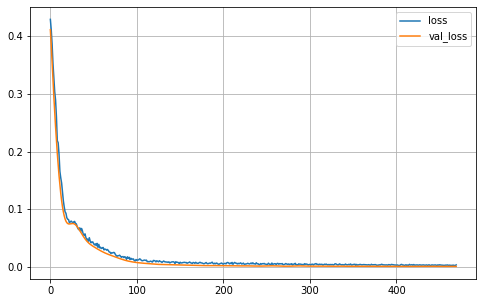

In [21]:
pd.DataFrame(Simple_Weight_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [22]:
hist_Simple_Weight_model_history = pd.DataFrame(Simple_Weight_model_history.history) 
# hist_Simple_Weight_model_history.to_pickle("../data/lstm_mlp/lstm_models/hist_Simple_Weight_model_history.pkl")

## LSTM with Dropout

### Define Model

In [23]:
def build_lstm_dropout():
    LSTMDropout_model = keras.models.Sequential([
        keras.layers.LSTM(16,
                          input_shape=(all_train_x.shape[1],all_train_x.shape[2]),
                          return_sequences=True,
                          dropout=0.3,
                          recurrent_dropout=0.3,
                          kernel_constraint=keras.constraints.max_norm(max_value=1),
                          recurrent_constraint=keras.constraints.max_norm(max_value=1),
                          ),

        keras.layers.LSTM(16,
                        return_sequences=False,
                        dropout=0.3,
                        recurrent_dropout=0.3,
                        kernel_constraint=keras.constraints.max_norm(max_value=1),
                        recurrent_constraint=keras.constraints.max_norm(max_value=1),
                         ),

        keras.layers.Dense(2, kernel_initializer='he_normal', activation='relu'),
    ])

    LSTMDropout_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))
    LSTMDropout_model.summary()
    
    return LSTMDropout_model

### Training

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
LSTMDropout_model_train = build_lstm_dropout()
LSTMDropout_history = LSTMDropout_model_train.fit(train_x, train_y,
                    epochs=100,
                    batch_size=128, 
                    validation_data=(valid_x, valid_y),
                    callbacks=[
                              callback,
                              ],
                    verbose=2
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 16)             2944      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 - 6s - loss: 0.5268 - val_loss: 0.5266
Epoch 2/100
1/1 - 0s - loss: 0.5235 - val_loss: 0.5217
Epoch 3/100
1/1 - 0s - loss: 0.5185 - val_loss: 0.5140
Epoch 4/100
1/1 - 0s - loss: 0.5104 - val_loss: 0.5020
Epoch 5/100
1/1 - 0s - loss: 0.4991 - val_loss: 0.4833
Epoch 6/100
1/1 - 0s - loss: 0.4853 - val_loss: 0.4626
Epoch 7/100
1/1 - 0s - loss: 0.4706 - val_loss: 0.44

In [25]:
## Predict Training Set and calculate RMSE
y_pred_train= LSTMDropout_model_train.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_pred_train_unsc, y_train_unsc))  

13.138100360630576

In [26]:
## Predict Validation Set and calculate RMSE
y_pred_valid= LSTMDropout_model_train.predict(valid_x)
y_valid_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_valid_unsc = scaler_train_y.inverse_transform(y_pred_valid)

np.sqrt(mean_squared_error(y_pred_valid_unsc, y_valid_unsc))  

13.138100360630578

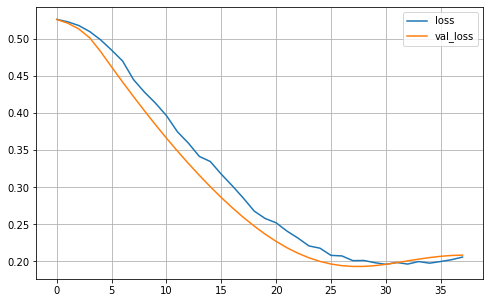

In [27]:
pd.DataFrame(LSTMDropout_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [28]:
hist_LSTMDropout_train = pd.DataFrame(LSTMDropout_history.history) 
# LSTMDropout_model_train.save("../data/lstm_mlp/lstm_models/LSTMDropout_model_train")
# hist_LSTMDropout_train.to_pickle("../data/lstm_mlp/lstm_models/hist_LSTMDropout_train.pkl")

### Testing

In [29]:
LSTMDropout_model_test = build_lstm_dropout()
LSTMDropout_history = LSTMDropout_model_test.fit(all_train_x, all_train_y,
                    epochs=99,
                    batch_size=128, 
                    verbose=2
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5, 16)             2944      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/99
1/1 - 5s - loss: 0.4687
Epoch 2/99
1/1 - 0s - loss: 0.4604
Epoch 3/99
1/1 - 0s - loss: 0.4371
Epoch 4/99
1/1 - 0s - loss: 0.4188
Epoch 5/99
1/1 - 0s - loss: 0.4025
Epoch 6/99
1/1 - 0s - loss: 0.3828
Epoch 7/99
1/1 - 0s - loss: 0.3651
Epoch 8/99
1/1 - 0s - loss: 0.3476
Epoch 9/99
1/1 - 0s - loss: 0.3271
Epoch 10/99
1/1 - 0s - loss: 0.3042
Epoch 11/99
1/1 - 0s - loss: 0.

Save final model

In [30]:
# LSTMDropout_model_test.save("../data/lstm_mlp/lstm_models/LSTMDropout_model_test")

In [31]:
y_pred_test= LSTMDropout_model_test.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  

2.529697575697921

### Test 5 times with different seeds

In [32]:
LSTMDropout_model = build_lstm_dropout()
epochs = 99
batch_size = 128
train_score, test_score = test_5_times(LSTMDropout_model, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 5, 16)             2944      
_________________________________________________________________
lstm_10 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 34        
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/99
1/1 [==============================] - 5s 5s/step - loss: 0.5189
Epoch 2/99
1/1 [==============================] - 0s 7ms/step - loss: 0.5137
Epoch 3/99
1/1 [==============================] - 0s 6ms/step - loss: 0.5004
Epoch 4/99
1/1 [==============================] - 0s 7ms/step - loss: 0.4853
Epoch 5/99
1/1 [==============================] - 0s 6ms/step - loss: 0.465

1/1 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 97/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0129
Epoch 98/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 99/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0136
Epoch 1/99
1/1 [==============================] - 1s 926ms/step - loss: 0.0136
Epoch 2/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0145
Epoch 3/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0145
Epoch 4/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 5/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 6/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 7/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 8/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 9/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch

1/1 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 3/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0081
Epoch 4/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 5/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 6/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 7/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 8/99
1/1 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 9/99
1/1 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 10/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 11/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 12/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 13/99
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 14/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch

1/1 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 8/99
1/1 [==============================] - 0s 8ms/step - loss: 0.0069
Epoch 9/99
1/1 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 10/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 11/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 12/99
1/1 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 13/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 14/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 15/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 16/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 17/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0067
Epoch 18/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 19/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0053


Epoch 13/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 14/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 15/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 16/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 17/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 18/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 19/99
1/1 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 20/99
1/1 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 21/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 22/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 23/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 24/99
1/1 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 25/99
1/1 [==============================] - 0s 7ms/step -

In [33]:
pd.DataFrame(train_score).describe()

,0
count,5.000000
mean,1.892626
std,0.523040
min,1.554748
25%,1.616368
50%,1.685215
75%,1.791875
max,2.814924


In [34]:
pd.DataFrame(test_score).describe()

,0
count,5.000000
mean,1.892626
std,0.523040
min,1.554748
25%,1.616368
50%,1.685215
75%,1.791875
max,2.814924


### LSTM with weight regularization

### Build Model

In [35]:
def build_lstm_weight_reg():
    LSTMWeightDecay_model = keras.models.Sequential([
        keras.layers.LSTM(16,
                          input_shape=(train_x.shape[1],train_x.shape[2]),
                          return_sequences=True,
                          kernel_regularizer=regularizers.l2(0.0001),
                          recurrent_regularizer=regularizers.l2(0.0001),
                          ),


        keras.layers.LSTM(16,
                        return_sequences=False,
                        kernel_regularizer=regularizers.l2(0.0001),
                        recurrent_regularizer=regularizers.l2(0.0001),
                        ),

        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])

    LSTMWeightDecay_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))
    LSTMWeightDecay_model.summary()
    
    return LSTMWeightDecay_model

### Training

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
LSTMWeightDecay_model = build_lstm_weight_reg()
LSTMWeightDecay_history = LSTMWeightDecay_model.fit(train_x, train_y,
                    epochs=300,
                    batch_size=128, 
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback],          
                    verbose=2
                   )


C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 5, 16)             2944      
_________________________________________________________________
lstm_12 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 34        
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
1/1 - 5s - loss: 0.6877 - val_loss: 0.6463
Epoch 2/300
1/1 - 0s - loss: 0.6463 - val_loss: 0.6062
Epoch 3/300
1/1 - 0s - loss: 0.6062 - val_loss: 0.5673
Epoch 4/300
1/1 - 0s - loss: 0.5673 - val_loss: 0.5297
Epoch 5/300
1/1 - 0s - loss: 0.5297 - val_loss: 0.4933
Epoch 6/300
1/1 - 0s - loss: 0.4933 - val_loss: 0.4582
Epoch 7/300
1/1 - 0s - loss: 0.4582 - val_loss: 0.42

Epoch 134/300
1/1 - 0s - loss: 0.0110 - val_loss: 0.0110
Epoch 135/300
1/1 - 0s - loss: 0.0110 - val_loss: 0.0109
Epoch 136/300
1/1 - 0s - loss: 0.0109 - val_loss: 0.0109
Epoch 137/300
1/1 - 0s - loss: 0.0109 - val_loss: 0.0109
Epoch 138/300
1/1 - 0s - loss: 0.0109 - val_loss: 0.0108
Epoch 139/300
1/1 - 0s - loss: 0.0108 - val_loss: 0.0108
Epoch 140/300
1/1 - 0s - loss: 0.0108 - val_loss: 0.0108
Epoch 141/300
1/1 - 0s - loss: 0.0108 - val_loss: 0.0108
Epoch 142/300
1/1 - 0s - loss: 0.0108 - val_loss: 0.0107
Epoch 143/300
1/1 - 0s - loss: 0.0107 - val_loss: 0.0107
Epoch 144/300
1/1 - 0s - loss: 0.0107 - val_loss: 0.0107
Epoch 145/300
1/1 - 0s - loss: 0.0107 - val_loss: 0.0106
Epoch 146/300
1/1 - 0s - loss: 0.0106 - val_loss: 0.0106
Epoch 147/300
1/1 - 0s - loss: 0.0106 - val_loss: 0.0106
Epoch 148/300
1/1 - 0s - loss: 0.0106 - val_loss: 0.0105
Epoch 149/300
1/1 - 0s - loss: 0.0105 - val_loss: 0.0105
Epoch 150/300
1/1 - 0s - loss: 0.0105 - val_loss: 0.0105
Epoch 151/300
1/1 - 0s - loss: 

Epoch 278/300
1/1 - 0s - loss: 0.0083 - val_loss: 0.0082
Epoch 279/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 280/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 281/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 282/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 283/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 284/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 285/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 286/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0082
Epoch 287/300
1/1 - 0s - loss: 0.0082 - val_loss: 0.0081
Epoch 288/300
1/1 - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 289/300
1/1 - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 290/300
1/1 - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 291/300
1/1 - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 292/300
1/1 - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 293/300
1/1 - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 294/300
1/1 - 0s - loss: 0.0081 - val_loss: 0.0081
Epoch 295/300
1/1 - 0s - loss: 

### Performance

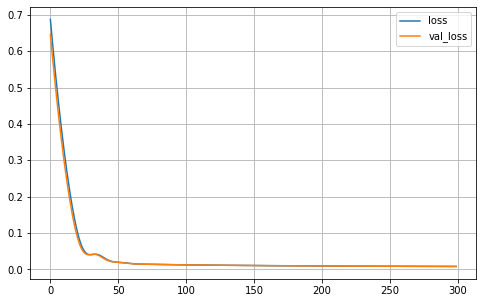

In [37]:
pd.DataFrame(LSTMWeightDecay_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [38]:
hist_LSTMWeightDecay_train = pd.DataFrame(LSTMWeightDecay_history.history) 
# hist_LSTMWeightDecay_train.to_pickle("../data/lstm_mlp/lstm_models/hist_LSTMWeightDecay_train.pkl")

In [39]:
## Predict Training Set and calculate RMSE
y_pred_train= LSTMWeightDecay_model.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_pred_train_unsc, y_train_unsc))  

1.2479255149622044

In [40]:
## Predict Validation Set and calculate RMSE
y_pred_valid= LSTMWeightDecay_model.predict(valid_x)
y_valid_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_valid_unsc = scaler_train_y.inverse_transform(y_pred_valid)

np.sqrt(mean_squared_error(y_pred_valid_unsc, y_valid_unsc))  

1.2479255149622044

### Testing

In [41]:
LSTMWeightDecay_model = build_lstm_weight_reg()
LSTMWeightDecay_history = LSTMWeightDecay_model.fit(all_train_x, all_train_y,
                    epochs=230,
                    batch_size=128,        
                    verbose=2
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 5, 16)             2944      
_________________________________________________________________
lstm_14 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/230
1/1 - 3s - loss: 0.3929
Epoch 2/230
1/1 - 0s - loss: 0.3690
Epoch 3/230
1/1 - 0s - loss: 0.3457
Epoch 4/230
1/1 - 0s - loss: 0.3232
Epoch 5/230
1/1 - 0s - loss: 0.3014
Epoch 6/230
1/1 - 0s - loss: 0.2803
Epoch 7/230
1/1 - 0s - loss: 0.2600
Epoch 8/230
1/1 - 0s - loss: 0.2404
Epoch 9/230
1/1 - 0s - loss: 0.2215
Epoch 10/230
1/1 - 0s - loss: 0.2034
Epoch 11/230
1/1 - 0s

Epoch 200/230
1/1 - 0s - loss: 0.0087
Epoch 201/230
1/1 - 0s - loss: 0.0086
Epoch 202/230
1/1 - 0s - loss: 0.0086
Epoch 203/230
1/1 - 0s - loss: 0.0086
Epoch 204/230
1/1 - 0s - loss: 0.0086
Epoch 205/230
1/1 - 0s - loss: 0.0085
Epoch 206/230
1/1 - 0s - loss: 0.0085
Epoch 207/230
1/1 - 0s - loss: 0.0085
Epoch 208/230
1/1 - 0s - loss: 0.0085
Epoch 209/230
1/1 - 0s - loss: 0.0085
Epoch 210/230
1/1 - 0s - loss: 0.0084
Epoch 211/230
1/1 - 0s - loss: 0.0084
Epoch 212/230
1/1 - 0s - loss: 0.0084
Epoch 213/230
1/1 - 0s - loss: 0.0084
Epoch 214/230
1/1 - 0s - loss: 0.0083
Epoch 215/230
1/1 - 0s - loss: 0.0083
Epoch 216/230
1/1 - 0s - loss: 0.0083
Epoch 217/230
1/1 - 0s - loss: 0.0083
Epoch 218/230
1/1 - 0s - loss: 0.0083
Epoch 219/230
1/1 - 0s - loss: 0.0083
Epoch 220/230
1/1 - 0s - loss: 0.0082
Epoch 221/230
1/1 - 0s - loss: 0.0082
Epoch 222/230
1/1 - 0s - loss: 0.0082
Epoch 223/230
1/1 - 0s - loss: 0.0082
Epoch 224/230
1/1 - 0s - loss: 0.0082
Epoch 225/230
1/1 - 0s - loss: 0.0081
Epoch 226/23

In [42]:
## Predicit test set and calculate RMSE
y_pred_test= LSTMWeightDecay_model.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  

1.2027083504712759

### Test 5 times with different seeds

In [43]:
LSTMWeightDecay_model = build_lstm_weight_reg()
epochs = 75
batch_size = 128
train_score, test_score = test_5_times(LSTMWeightDecay_model, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 16)             2944      
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 34        
Total params: 5,090
Trainable params: 5,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
1/1 [==============================] - 5s 5s/step - loss: 0.5194
Epoch 2/75
1/1 [==============================] - 0s 7ms/step - loss: 0.4905
Epoch 3/75
1/1 [==============================] - 0s 6ms/step - loss: 0.4621
Epoch 4/75
1/1 [==============================] - 0s 7ms/step - loss: 0.4341
Epoch 5/75
1/1 [==============================] - 0s 7ms/step - loss: 0.40

1/1 [==============================] - 0s 8ms/step - loss: 0.0124
Epoch 22/75
1/1 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 23/75
1/1 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 24/75
1/1 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 25/75
1/1 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 26/75
1/1 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 27/75
1/1 [==============================] - 0s 8ms/step - loss: 0.0121
Epoch 28/75
1/1 [==============================] - 0s 8ms/step - loss: 0.0121
Epoch 29/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 30/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 31/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 32/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 33/75
1/1 [==============================] - 0s 8ms/step - loss: 0.011

1/1 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 52/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 53/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 54/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 55/75
1/1 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 56/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 57/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 58/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 59/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 60/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 61/75
1/1 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 62/75
1/1 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 63/75
1/1 [==============================] - ETA: 0s - loss: 0.008 - 0

Epoch 6/75
1/1 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 7/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 8/75
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 9/75
1/1 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 10/75
1/1 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 11/75
1/1 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 12/75
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 13/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 14/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 15/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 16/75
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 17/75
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 18/75
1/1 [==============================] - 0s 8ms/step - los

In [44]:
pd.DataFrame(train_score).describe()

,0
count,5.000000
mean,1.530343
std,0.543309
min,1.085654
25%,1.169686
50%,1.312647
75%,1.666215
max,2.417510


In [45]:
pd.DataFrame(test_score).describe()

,0
count,5.000000
mean,1.530343
std,0.543309
min,1.085654
25%,1.169686
50%,1.312647
75%,1.666215
max,2.417510


## LSTM with Hyperband

### Keras Tuner implementation of Hyperband
Hyperparameter search may take a while even with limited data, resulting architectur when used with all data is provided next. Hyperband was not run for the limited data, but can be run.

In [46]:
# ## Model architecture and Hyperparameter with search spaces
# def model_builder (hp):
    
#     model = keras.models.Sequential()
    
#     ## Define Hyperparameter search space
#     hp_units = hp.Int("unit",min_value=30,max_value=320,step=32)
#     hp_dropout=hp.Choice("dropout",values = [0.2, 0.3, 0.4])  
#     hp_number_of_layers = hp.Int("nr_layers",min_value=3,max_value=8,step=1)
    
#     model.add(keras.layers.LSTM(
#                         units=hp_units, 
#                         dropout=hp_dropout,          
#                         recurrent_dropout=hp_dropout,                       
#                         return_sequences=True,
#                         input_shape=(train_x.shape[1],train_x.shape[2]),  
#                         kernel_constraint=keras.constraints.max_norm(max_value=1),
#                         recurrent_constraint=keras.constraints.max_norm(max_value=1),
#                  ))
    
#     for i in range(hp_number_of_layers):
#         model.add(keras.layers.LSTM(
#                         units=hp_units, 
#                         dropout=hp_dropout,          
#                         recurrent_dropout=hp_dropout, 
#                         return_sequences=True,
#                         kernel_constraint=keras.constraints.max_norm(max_value=1),
#                         recurrent_constraint=keras.constraints.max_norm(max_value=1),
        
#         ))
        
        
        
#     model.add(keras.layers.LSTM(
#                         units=hp_units, 
#                         dropout=hp_dropout,          
#                         recurrent_dropout=hp_dropout, 
#                         return_sequences=False,  
#                         kernel_constraint=keras.constraints.max_norm(max_value=1),
#                         recurrent_constraint=keras.constraints.max_norm(max_value=1),
#                  ))
    
 
#     model.add(keras.layers.Dense(2, kernel_initializer='he_normal'))
        
#     hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 1e-4])
#     optimizer = keras.optimizers.Adam(lr=hp_learning_rate)
    
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
#     return model



# ## Let Hyperband also search for best batch size
# class MyTuner(kt.tuners.Hyperband):
#     def run_trial(self, trial, *args, **kwargs):
#         kwargs['batch_size'] = trial.hyperparameters.Choice("batch_size",values = [32, 128, 512])
#         super(MyTuner, self).run_trial(trial, *args, **kwargs)

# import os

# ## Let Hyperband run
# tuner = MyTuner(model_builder,
#     objective='val_loss',
#     max_epochs = 50,
#     factor = 3,
#     seed = 42,
#     directory = os.path.normpath('k'), #when running on windows, the path name needs to be as short
#     project_name = 'k5')               #as possible, since keras tuner uses long names for files
#                                        #and windows does only support directories with names up to 260 characters

In [47]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# tuner.search(train_x,
#     train_y,
#     epochs = 50,
#     validation_data = (valid_x, valid_y),
#     callbacks = [stop_early]
# )


### Training

#### Either: Rebuild best model with tuned hyperparameters and find best number of epochs

In [48]:
# tuner = pickle.load(open("../data/lstm_mlp/lstm_models/lstm_keras_tuner.pkl",'rb'))
# print(tuner.get_best_hyperparameters()[0].values)

In [49]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# hypermodel_lstm = tuner.hypermodel.build(best_hps)
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# # Retrain the model
# hypermodel_lstm_history = hypermodel_lstm.fit(train_x, train_y,
#                     epochs=100,
#                     batch_size=32,
#                     validation_data=(valid_x, valid_y),
#                     callbacks=[early_stop]
#                    )

#### Or: Rebuild best Hyperband model manually

In [50]:
def build_hyperband_lstm():
    hypermodel_lstm = keras.models.Sequential([
        keras.layers.LSTM(94,
                          input_shape=(train_x.shape[1],train_x.shape[2]),
                          return_sequences=True,
                          dropout=0.2,
                          recurrent_dropout=0.2,
                          ),

        keras.layers.LSTM(94,
                          dropout=0.2,
                          recurrent_dropout=0.2, 
                          return_sequences=True,
                          ),

        keras.layers.LSTM(94,
                          dropout=0.2,
                          recurrent_dropout=0.2, 
                          return_sequences=True,
                          ),

        keras.layers.LSTM(94,
                          dropout=0.2,
                          recurrent_dropout=0.2, 
                          return_sequences=True,
                          ),


         keras.layers.LSTM(94,
                          dropout=0.2,
                          recurrent_dropout=0.2, 
                          return_sequences=False,
                          ),

       keras.layers.Dense(2, kernel_initializer='he_normal')
    ])

    hypermodel_lstm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))
    hypermodel_lstm.summary() 
    return hypermodel_lstm

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
hypermodel_lstm = build_hyperband_lstm()
hypermodel_lstm_history = hypermodel_lstm.fit(train_x, train_y,
                    epochs=100,
                    batch_size=128,
                    validation_data=(valid_x, valid_y),
                    callbacks=[early_stop]
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 5, 94)             46624     
_________________________________________________________________
lstm_18 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_19 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_20 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_21 (LSTM)               (None, 94)                71064     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 190       
Total params: 331,070
Trainable params: 331,070
Non-trainable params: 0
_______________________________________________

1/1 [==============================] - 0s 66ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 73/100
1/1 [==============================] - 0s 57ms/step - loss: 0.0089 - val_loss: 0.0046
Epoch 74/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0076 - val_loss: 0.0044
Epoch 75/100
1/1 [==============================] - 0s 56ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 76/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 77/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 78/100
1/1 [==============================] - 0s 56ms/step - loss: 0.0077 - val_loss: 0.0040
Epoch 79/100
1/1 [==============================] - 0s 54ms/step - loss: 0.0068 - val_loss: 0.0039
Epoch 80/100
1/1 [==============================] - 0s 54ms/step - loss: 0.0081 - val_loss: 0.0038
Epoch 81/100
1/1 [==============================] - 0s 56ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 82/100
1/1 [=====

#### Performance

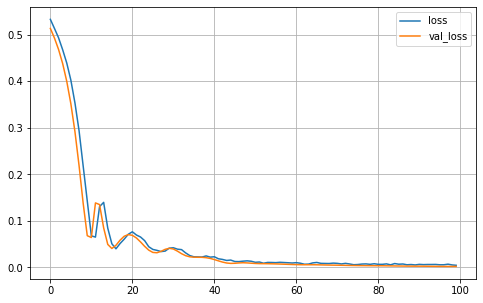

In [51]:
pd.DataFrame(hypermodel_lstm_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [52]:
hist_LSTMHyperband_train = pd.DataFrame(hypermodel_lstm_history.history) 
# hist_LSTMHyperband_train.to_pickle("../data/lstm_mlp/lstm_models/hist_LSTMHyperband_train.pkl")

In [53]:
## Predict Training Set and calculate RMSE
y_pred_train= hypermodel_lstm.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_pred_train_unsc, y_train_unsc))  

1.7473668458014198

In [54]:
## Predict Validation Set and calculate RMSE
y_pred_valid= hypermodel_lstm.predict(valid_x)
y_valid_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_valid_unsc = scaler_train_y.inverse_transform(y_pred_valid)

np.sqrt(mean_squared_error(y_pred_valid_unsc, y_valid_unsc))  

1.7473668458014198

### Testing
#### Either: rebuild Keras Tuner model

In [55]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# hypermodel_lstm = tuner.hypermodel.build(best_hps)
# # Retrain the model
# history = hypermodel_lstm.fit(all_train_x, all_train_y,
#                     epochs=31,
#                     batch_size=32,
#                    )

#### Or: rebuild best model manually

In [56]:
hypermodel_lstm = build_hyperband_lstm()
hypermodel_lstm_history = hypermodel_lstm.fit(all_train_x, all_train_y,
                    epochs=31,
                    batch_size=128,
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 5, 94)             46624     
_________________________________________________________________
lstm_23 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_24 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_25 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_26 (LSTM)               (None, 94)                71064     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 190       
Total params: 331,070
Trainable params: 331,070
Non-trainable params: 0
_______________________________________________

In [57]:
## Predicit test set and calculate RMSE
y_pred_test= hypermodel_lstm.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  

6.245711474888336

### Test 5 times with different seeds

In [58]:
hypermodel_lstm = build_hyperband_lstm()
epochs = 31
batch_size = 128
train_score, test_score = test_5_times(hypermodel_lstm, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 5, 94)             46624     
_________________________________________________________________
lstm_28 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_29 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_31 (LSTM)               (None, 94)                71064     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 190       
Total params: 331,070
Trainable params: 331,070
Non-trainable params: 0
_______________________________________________

1/1 [==============================] - 0s 58ms/step - loss: 0.0065
Epoch 29/31
1/1 [==============================] - 0s 54ms/step - loss: 0.0066
Epoch 30/31
1/1 [==============================] - 0s 54ms/step - loss: 0.0069
Epoch 31/31
1/1 [==============================] - 0s 58ms/step - loss: 0.0070
Epoch 1/31
1/1 [==============================] - 3s 3s/step - loss: 0.0063
Epoch 2/31
1/1 [==============================] - 0s 43ms/step - loss: 0.0067
Epoch 3/31
1/1 [==============================] - 0s 43ms/step - loss: 0.0063
Epoch 4/31
1/1 [==============================] - 0s 45ms/step - loss: 0.0057
Epoch 5/31
1/1 [==============================] - 0s 45ms/step - loss: 0.0053
Epoch 6/31
1/1 [==============================] - 0s 47ms/step - loss: 0.0062
Epoch 7/31
1/1 [==============================] - 0s 48ms/step - loss: 0.0045
Epoch 8/31
1/1 [==============================] - 0s 48ms/step - loss: 0.0061
Epoch 9/31
1/1 [==============================] - 0s 48ms/step - loss: 0.0

In [59]:
pd.DataFrame(train_score).describe()

,0
count,5.000000
mean,2.436858
std,1.283222
min,1.371667
25%,1.608148
50%,2.015742
75%,2.617575
max,4.571160


In [60]:
pd.DataFrame(test_score).describe()

,0
count,5.000000
mean,2.436858
std,1.283222
min,1.371667
25%,1.608148
50%,2.015742
75%,2.617575
max,4.571160


### PeepholeDropout

In [61]:
def build_peephole_dropout():
    PeepholeDropout_model = keras.models.Sequential([

        keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(16, 
                         dropout=0.3,
                         recurrent_dropout=0.3,
                         kernel_constraint=keras.constraints.max_norm(max_value=1),
                         recurrent_constraint=keras.constraints.max_norm(max_value=1)
                                                                ),
                          return_sequences=True,
                        input_shape=(train_x.shape[1],train_x.shape[2]),
                        ),
         keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(16, 
                         dropout=0.3,
                         recurrent_dropout=0.3,
                         kernel_constraint=keras.constraints.max_norm(max_value=1),
                         recurrent_constraint=keras.constraints.max_norm(max_value=1)
                                                                ),
                          return_sequences=True),

         keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(16, 
                         dropout=0.3,
                         recurrent_dropout=0.3,
                         kernel_constraint=keras.constraints.max_norm(max_value=1),
                         recurrent_constraint=keras.constraints.max_norm(max_value=1),
                                                                ),
                          return_sequences=False),

        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])

    PeepholeDropout_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))                               
    PeepholeDropout_model.summary()
    
    return PeepholeDropout_model

### Training

In [62]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
PeepholeDropout_model = build_peephole_dropout()
PeepholeDropout_model_history = PeepholeDropout_model.fit(train_x, train_y,
                    epochs=100,
                    batch_size=128, 
                    validation_data=(valid_x, valid_y),
                    callbacks=[callback],
                    verbose=2
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\recurrent.py:2570: UserWarning: `tf.keras.experimental.PeepholeLSTMCell` is deprecated and will be removed in a future version. Please use tensorflow_addons.rnn.PeepholeLSTMCell instead.
  warnings.warn('`tf.keras.experimental.PeepholeLSTMCell` is deprecated '
C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 5, 16)             2992      
_________________________________________________________________
rnn_1 (RNN)                  (None, 5, 16)             2160      
_________________________________________________________________
rnn_2 (RNN)                  (None, 16)                2160      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 34        
Total params: 7,346
Trainable params: 7,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 - 14s - loss: 0.5282 - val_loss: 0.5116
Epoch 2/100
1/1 - 0s - loss: 0.5091 - val_loss: 0.4956
Epoch 3/100
1/1 - 0s - loss: 0.4983 - val_loss: 0.4800
Epoch 4/100
1/1 - 0s - loss: 0.4812 - val_loss: 0.4646
Epoch 5/100
1/1 - 0s - loss:

#### Performance

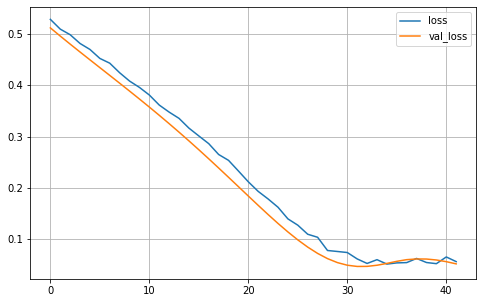

In [63]:
pd.DataFrame(PeepholeDropout_model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [64]:
hist_PeepholeDropout_train = pd.DataFrame(PeepholeDropout_model_history.history) 
# hist_PeepholeDropout_train.to_pickle("../data/lstm_mlp/lstm_models/hist_PeepholeDropout_train.pkl")

In [65]:
## Predict Training Set and calculate RMSE
y_pred_train= PeepholeDropout_model.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_pred_train_unsc, y_train_unsc))  

7.282004142516835

In [66]:
## Predict Validation Set and calculate RMSE
y_pred_valid= PeepholeDropout_model.predict(valid_x)
y_valid_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_valid_unsc = scaler_train_y.inverse_transform(y_pred_valid)

np.sqrt(mean_squared_error(y_pred_valid_unsc, y_valid_unsc))  

7.282004496366929

### Testing

In [67]:
PeepholeDropout_model = build_peephole_dropout()
PeepholeDropout_model_history = PeepholeDropout_model.fit(all_train_x, all_train_y,
                    epochs=43,
                    batch_size=128, 
                    verbose=2
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\recurrent.py:2570: UserWarning: `tf.keras.experimental.PeepholeLSTMCell` is deprecated and will be removed in a future version. Please use tensorflow_addons.rnn.PeepholeLSTMCell instead.
  warnings.warn('`tf.keras.experimental.PeepholeLSTMCell` is deprecated '
C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_3 (RNN)                  (None, 5, 16)             2992      
_________________________________________________________________
rnn_4 (RNN)                  (None, 5, 16)             2160      
_________________________________________________________________
rnn_5 (RNN)                  (None, 16)                2160      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 34        
Total params: 7,346
Trainable params: 7,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/43
1/1 - 15s - loss: 0.5281
Epoch 2/43
1/1 - 0s - loss: 0.5152
Epoch 3/43
1/1 - 0s - loss: 0.5019
Epoch 4/43
1/1 - 0s - loss: 0.4885
Epoch 5/43
1/1 - 0s - loss: 0.4695
Epoch 6/43
1/1 - 0s - loss: 0.4612
Epoch 7/43
1/1 - 0s - loss: 0.4444
Epo

In [68]:
## Predicit test set and calculate RMSE
y_pred_test= PeepholeDropout_model.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  

5.3284930796190615

### Test 5 times with different seeds

In [69]:
PeepholeDropout_model = build_peephole_dropout()
epochs = 43
batch_size = 128
train_score, test_score = test_5_times(PeepholeDropout_model, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\recurrent.py:2570: UserWarning: `tf.keras.experimental.PeepholeLSTMCell` is deprecated and will be removed in a future version. Please use tensorflow_addons.rnn.PeepholeLSTMCell instead.
  warnings.warn('`tf.keras.experimental.PeepholeLSTMCell` is deprecated '
C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_6 (RNN)                  (None, 5, 16)             2992      
_________________________________________________________________
rnn_7 (RNN)                  (None, 5, 16)             2160      
_________________________________________________________________
rnn_8 (RNN)                  (None, 16)                2160      
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 34        
Total params: 7,346
Trainable params: 7,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/43
1/1 [==============================] - 12s 12s/step - loss: 0.5122
Epoch 2/43
1/1 [==============================] - 0s 16ms/step - loss: 0.4913
Epoch 3/43
1/1 [==============================] - 0s 15ms/step - loss: 0.4741
Epoch 4/43
1/1 

1/1 [==============================] - 0s 16ms/step - loss: 0.0151
Epoch 8/43
1/1 [==============================] - 0s 16ms/step - loss: 0.0157
Epoch 9/43
1/1 [==============================] - 0s 17ms/step - loss: 0.0192
Epoch 10/43
1/1 [==============================] - 0s 17ms/step - loss: 0.0197
Epoch 11/43
1/1 [==============================] - 0s 17ms/step - loss: 0.0133
Epoch 12/43
1/1 [==============================] - 0s 18ms/step - loss: 0.0174
Epoch 13/43
1/1 [==============================] - 0s 18ms/step - loss: 0.0168
Epoch 14/43
1/1 [==============================] - 0s 18ms/step - loss: 0.0167
Epoch 15/43
1/1 [==============================] - 0s 17ms/step - loss: 0.0185
Epoch 16/43
1/1 [==============================] - 0s 17ms/step - loss: 0.0138
Epoch 17/43
1/1 [==============================] - 0s 17ms/step - loss: 0.0158
Epoch 18/43
1/1 [==============================] - 0s 18ms/step - loss: 0.0149
Epoch 19/43
1/1 [==============================] - 0s 18ms/step - 

1/1 [==============================] - 0s 18ms/step - loss: 0.0091
Epoch 25/43
1/1 [==============================] - 0s 19ms/step - loss: 0.0119
Epoch 26/43
1/1 [==============================] - 0s 20ms/step - loss: 0.0105
Epoch 27/43
1/1 [==============================] - ETA: 0s - loss: 0.011 - 0s 18ms/step - loss: 0.0118
Epoch 28/43
1/1 [==============================] - 0s 18ms/step - loss: 0.0106
Epoch 29/43
1/1 [==============================] - 0s 19ms/step - loss: 0.0096
Epoch 30/43
1/1 [==============================] - 0s 18ms/step - loss: 0.0129
Epoch 31/43
1/1 [==============================] - 0s 18ms/step - loss: 0.0110
Epoch 32/43
1/1 [==============================] - 0s 17ms/step - loss: 0.0096
Epoch 33/43
1/1 [==============================] - 0s 19ms/step - loss: 0.0105
Epoch 34/43
1/1 [==============================] - 0s 19ms/step - loss: 0.0088
Epoch 35/43
1/1 [==============================] - 0s 18ms/step - loss: 0.0121
Epoch 36/43
1/1 [=======================

In [70]:
pd.DataFrame(train_score).describe()

,0
count,5.000000
mean,2.940420
std,1.681335
min,1.651891
25%,1.884142
50%,2.373466
75%,2.987237
max,5.805362


In [71]:
pd.DataFrame(test_score).describe()

,0
count,5.000000
mean,2.940420
std,1.681335
min,1.651891
25%,1.884142
50%,2.373466
75%,2.987237
max,5.805362


### PeepholeHyperband
We use the same architecture we found using Hyperband for the standard LSTM modell

### Training

In [72]:
def build_hyperband_peephole():
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

    model = keras.models.Sequential([

        keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(94, 
                         dropout=0.3,
                         recurrent_dropout=0.3,
                         kernel_constraint=keras.constraints.max_norm(max_value=4),
                         recurrent_constraint=keras.constraints.max_norm(max_value=4),
                                                                ),
                          return_sequences=True,
                        input_shape=(train_x.shape[1],train_x.shape[2]),
                        ),

         keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(94, 
                         dropout=0.3,
                         recurrent_dropout=0.3,
                         kernel_constraint=keras.constraints.max_norm(max_value=4),
                         recurrent_constraint=keras.constraints.max_norm(max_value=4),
                                                                ),
                          return_sequences=True),


         keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(94, 
                         dropout=0.3,
                         recurrent_dropout=0.3,
                        kernel_constraint=keras.constraints.max_norm(max_value=4),
                         recurrent_constraint=keras.constraints.max_norm(max_value=4),                                        
                                                                ),
                          return_sequences=True),

          keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(94, 
                         dropout=0.3,
                         recurrent_dropout=0.3,
                         kernel_constraint=keras.constraints.max_norm(max_value=4),
                         recurrent_constraint=keras.constraints.max_norm(max_value=4),
                                                                ),
                          return_sequences=True),



        keras.layers.RNN(tf.keras.experimental.PeepholeLSTMCell(94, 
                         dropout=0.3,
                         recurrent_dropout=0.3,
                        kernel_constraint=keras.constraints.max_norm(max_value=4),
                         recurrent_constraint=keras.constraints.max_norm(max_value=4),                                       
                                                                ),
                          return_sequences=False),

        keras.layers.Dense(2, kernel_initializer='he_normal')
    ])

    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['mae'])
    model.summary() 
    return hypermodel_lstm


In [73]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
hypermodel_peephole = build_hyperband_peephole()
hypermodel_peephole_history = hypermodel_peephole.fit(train_x, train_y,
                    epochs=100,
                    batch_size=128,
                    validation_data=(valid_x, valid_y),
                    callbacks=[early_stop]
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\recurrent.py:2570: UserWarning: `tf.keras.experimental.PeepholeLSTMCell` is deprecated and will be removed in a future version. Please use tensorflow_addons.rnn.PeepholeLSTMCell instead.
  warnings.warn('`tf.keras.experimental.PeepholeLSTMCell` is deprecated '
C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_9 (RNN)                  (None, 5, 94)             46906     
_________________________________________________________________
rnn_10 (RNN)                 (None, 5, 94)             71346     
_________________________________________________________________
rnn_11 (RNN)                 (None, 5, 94)             71346     
_________________________________________________________________
rnn_12 (RNN)                 (None, 5, 94)             71346     
_________________________________________________________________
rnn_13 (RNN)                 (None, 94)                71346     
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 190       
Total params: 332,480
Trainable params: 332,480
Non-trainable params: 0
_______________________________________________

#### Performance

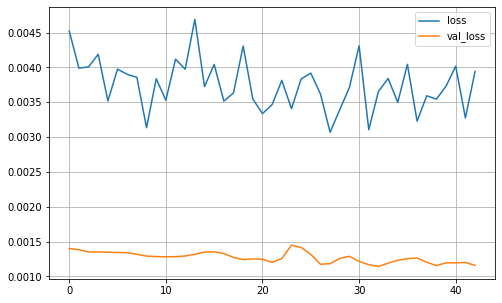

In [74]:
pd.DataFrame(hypermodel_peephole_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [75]:
hist_PeepholeHyperband_train = pd.DataFrame(hypermodel_peephole_history.history) 
# hist_PeepholeHyperband_train.to_pickle("../data/lstm_mlp/lstm_models/hist_PeepholeHyperband_train.pkl")

In [76]:
## Predict Training Set and calculate RMSE
y_pred_train= hypermodel_peephole.predict(train_x)
y_train_unsc = scaler_train_y.inverse_transform(train_y)
y_pred_train_unsc = scaler_train_y.inverse_transform(y_pred_train)

np.sqrt(mean_squared_error(y_pred_train_unsc, y_train_unsc))  

1.2535051096145646

In [77]:
## Predict Validation Set and calculate RMSE
y_pred_valid= hypermodel_peephole.predict(valid_x)
y_valid_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_valid_unsc = scaler_train_y.inverse_transform(y_pred_valid)

np.sqrt(mean_squared_error(y_pred_valid_unsc, y_valid_unsc))  

1.2535051096145648

### Testing

In [78]:
hypermodel_peephole = build_hyperband_lstm()
hypermodel_peephole_history = hypermodel_peephole.fit(all_train_x, all_train_y,
                    epochs=28,
                    batch_size=128,
                   )

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 5, 94)             46624     
_________________________________________________________________
lstm_33 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_34 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_35 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_36 (LSTM)               (None, 94)                71064     
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 190       
Total params: 331,070
Trainable params: 331,070
Non-trainable params: 0
_______________________________________________

In [79]:
## Predicit test set and calculate RMSE
y_pred_test= hypermodel_peephole.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)

np.sqrt(mean_squared_error(y_pred_test_unsc, y_test_unsc))  

5.91384515798511

### Test 5 times with different seeds

In [80]:
hypermodel_peephole = build_hyperband_lstm()
epochs = 28
batch_size = 128
train_score, test_score = test_5_times(hypermodel_peephole, epochs, batch_size)

C:\Users\Enrico\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 5, 94)             46624     
_________________________________________________________________
lstm_38 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_39 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_40 (LSTM)               (None, 5, 94)             71064     
_________________________________________________________________
lstm_41 (LSTM)               (None, 94)                71064     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 190       
Total params: 331,070
Trainable params: 331,070
Non-trainable params: 0
_______________________________________________

Epoch 6/28
1/1 [==============================] - 0s 110ms/step - loss: 0.0070
Epoch 7/28
1/1 [==============================] - 0s 104ms/step - loss: 0.0062
Epoch 8/28
1/1 [==============================] - 0s 102ms/step - loss: 0.0070
Epoch 9/28
1/1 [==============================] - 0s 102ms/step - loss: 0.0057
Epoch 10/28
1/1 [==============================] - 0s 100ms/step - loss: 0.0062
Epoch 11/28
1/1 [==============================] - 0s 151ms/step - loss: 0.0068
Epoch 12/28
1/1 [==============================] - 0s 175ms/step - loss: 0.0069
Epoch 13/28
1/1 [==============================] - 0s 110ms/step - loss: 0.0065
Epoch 14/28
1/1 [==============================] - 0s 121ms/step - loss: 0.0061
Epoch 15/28
1/1 [==============================] - 0s 127ms/step - loss: 0.0055
Epoch 16/28
1/1 [==============================] - 0s 133ms/step - loss: 0.0062
Epoch 17/28
1/1 [==============================] - 0s 95ms/step - loss: 0.0064
Epoch 18/28
1/1 [============================

In [81]:
pd.DataFrame(train_score).describe()

,0
count,5.000000
mean,3.049331
std,2.020955
min,1.397968
25%,1.792343
50%,2.362185
75%,3.251141
max,6.443018


In [82]:
pd.DataFrame(test_score).describe()

,0
count,5.000000
mean,3.049331
std,2.020955
min,1.397968
25%,1.792343
50%,2.362185
75%,3.251141
max,6.443018


# Graphics

In [83]:
sns.set_style("white")

### Plot Simple LSTMs

#### If not all models were run: Read saved files

In [84]:
# hist_LSTMSimple_model_history = pd.read_pickle("../data/lstm_mlp/lstm_models/hist_LSTMSimple_model_history.pkl")
# hist_Simple_Dropout_model_history = pd.read_pickle("../data/lstm_mlp/lstm_models/hist_Simple_Dropout_model_history.pkl")
# hist_Simple_Weight_model_history = pd.read_pickle("../data/lstm_mlp/lstm_models/hist_Simple_Weight_model_history.pkl")

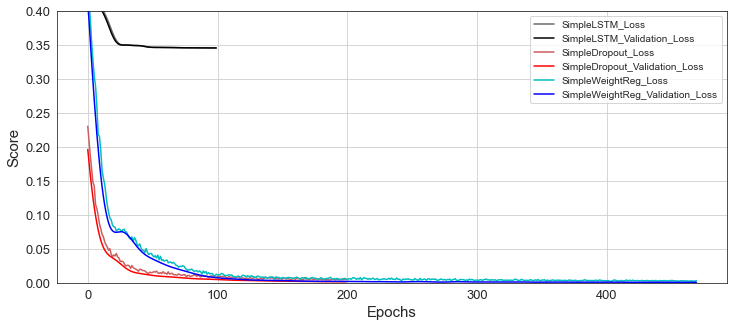

In [105]:
fig_simple_lstms, ax = plt.subplots(figsize=(12, 5))
ax.plot(hist_LSTMSimple_model_history['loss'], label='SimpleLSTM_Loss', color='dimgrey' )
ax.plot(hist_LSTMSimple_model_history['val_loss'], label='SimpleLSTM_Validation_Loss', color='black' )
ax.plot(hist_Simple_Dropout_model_history['loss'], label='SimpleDropout_Loss', color='indianred')
ax.plot(hist_Simple_Dropout_model_history['val_loss'], label='SimpleDropout_Validation_Loss', color='red')
ax.plot(hist_Simple_Weight_model_history['loss'], label='SimpleWeightReg_Loss', color='c')
ax.plot(hist_Simple_Weight_model_history['val_loss'], label='SimpleWeightReg_Validation_Loss', color='blue')
ax.set_ylim(0.0, 0.4)
ax.set(xlabel=' Epochs', ylabel='Score')
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Score', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
ax.legend(loc='upper right',prop={'size': 10} )
ax.grid()

### Plot Tunded LSTMs

#### If not all models were run: Read saved files

In [106]:
# hist_PeepholeHyperband_train = pd.read_pickle("../data/lstm_mlp/lstm_models/hist_PeepholeHyperband_train.pkl")
# hist_PeepholeDropout_train = pd.read_pickle("../data/lstm_mlp/lstm_models/hist_PeepholeDropout_train.pkl")
# hist_LSTMWeightDecay_train = pd.read_pickle("../data/lstm_mlp/lstm_models/hist_LSTMWeightDecay_train.pkl")
# hist_LSTMDropout_train = pd.read_pickle("../data/lstm_mlp/lstm_models/hist_LSTMDropout_train.pkl")
# hist_LSTMHyperband_train = pd.read_pickle("../data/lstm_mlp/lstm_models/hist_LSTMHyperband_train.pkl")

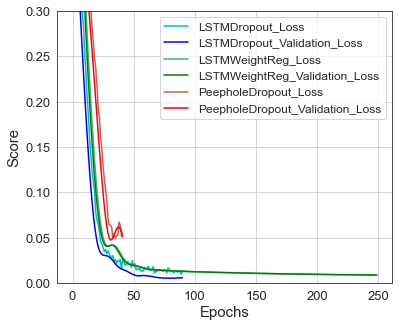

In [107]:
fig_simple_lstms, (ax1) = plt.subplots(figsize=(6, 5))
ax1.plot(hist_LSTMDropout_train['loss'], label='LSTMDropout_Loss', color='c')
ax1.plot(hist_LSTMDropout_train['val_loss'], label='LSTMDropout_Validation_Loss', color='blue')
ax1.plot(hist_LSTMWeightDecay_train['loss'][:250], label='LSTMWeightReg_Loss', color='mediumseagreen')
ax1.plot(hist_LSTMWeightDecay_train['val_loss'][:250], label='LSTMWeightReg_Validation_Loss', color='green')
ax1.plot(hist_PeepholeDropout_train['loss'], label='PeepholeDropout_Loss', color='indianred')
ax1.plot(hist_PeepholeDropout_train['val_loss'], label='PeepholeDropout_Validation_Loss', color='red')
ax1.set_ylim(0, 0.3)
ax1.set(xlabel=' Epochs', ylabel='Score')
ax1.set_xlabel('Epochs', fontsize=15)
ax1.set_ylabel('Score', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
ax1.legend(loc='best')
ax1.legend(prop={'size': 12})
ax1.grid()

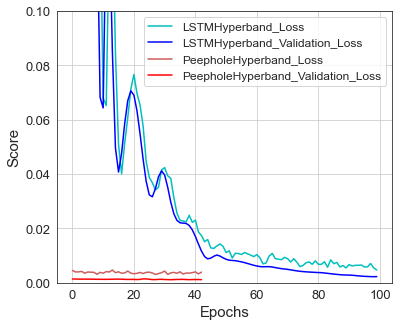

In [88]:
fig_simple_lstms, ax = plt.subplots(figsize=(6, 5))
ax.plot(hist_LSTMHyperband_train['loss'], label='LSTMHyperband_Loss', color='c' )
ax.plot(hist_LSTMHyperband_train['val_loss'], label='LSTMHyperband_Validation_Loss', color='blue' )
ax.plot(hist_PeepholeHyperband_train['loss'], label='PeepholeHyperband_Loss', color='indianred' )
ax.plot(hist_PeepholeHyperband_train['val_loss'], label='PeepholeHyperband_Validation_Loss', color='red' )
ax.set_ylim(0.000, 0.1)
ax.set(xlabel=' Epochs', ylabel='Score')
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Score', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
ax.legend(loc='best')
ax.legend(prop={'size': 12})
ax.grid()

### Grafical Evaluation

In [89]:
sns.set_style("white")

### If dropout lstm models was not run: Read saved files

In [108]:
# LSTMDropout_model_test = keras.models.load_model("../data/lstm_mlp/lstm_models/LSTMDropout_model_test")

# LSTMDropout_model_train = keras.models.load_model("../data/lstm_mlp/lstm_models/LSTMDropout_model_train")

In [109]:
y_pred_train = LSTMDropout_model_test.predict(all_train_x)
y_train_unsc = scaler_y.inverse_transform(all_train_y)
y_pred_train_unsc = scaler_y.inverse_transform(y_pred_train)
np.sqrt(mean_squared_error(y_train_unsc, y_pred_train_unsc))                       

2.5198796275604396

In [110]:
y_pred_valid = LSTMDropout_model_train.predict(valid_x)
y_valid_unsc = scaler_train_y.inverse_transform(valid_y)
y_pred_valid_unsc = scaler_train_y.inverse_transform(y_pred_valid)
np.sqrt(mean_squared_error(y_valid_unsc, y_pred_valid_unsc))                       

2.665112526388693

In [111]:
y_pred_test = LSTMDropout_model_test.predict(test_x)
y_test_unsc = scaler_y.inverse_transform(test_y)
y_pred_test_unsc = scaler_y.inverse_transform(y_pred_test)
np.sqrt(mean_squared_error(y_test_unsc, y_pred_test_unsc))                       

2.5198796275604396

### Scatter Plots

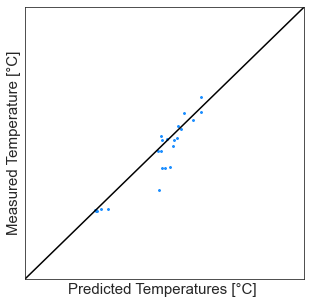

In [112]:
fig, ax1 = plt.subplots(1, figsize=(5, 5),  sharex=True, sharey=True)
plt.xlim(750, 800)
plt.ylim(750, 800)

ax1.scatter( y_pred_train_unsc, y_train_unsc, c= 'dodgerblue',s=1)
ax1.plot([750,800],[750,800], c='black')
ax1.grid()
ax1.set_xlabel('Predicted Temperatures [°C] ', fontsize=15)
ax1.set_ylabel('Measured Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 
ax1.set(xticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)

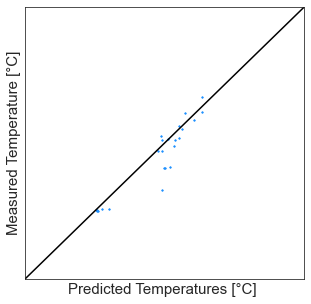

In [113]:
fig, ax1 = plt.subplots(1, figsize=(5, 5),  sharex=True, sharey=True)
plt.xlim(750, 800)
plt.ylim(750, 800)

ax1.scatter( y_pred_valid_unsc, y_valid_unsc, c= 'dodgerblue',s=1)
ax1.plot([750,800],[750,800], c='black')
ax1.grid()
ax1.set_xlabel('Predicted Temperatures [°C] ', fontsize=15)
ax1.set_ylabel('Measured Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 
ax1.set(xticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)

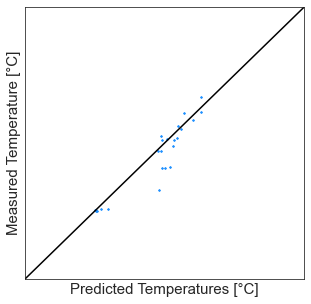

In [114]:
fig, ax1 = plt.subplots(1,  figsize=(5, 5),  sharex=True, sharey=True)
plt.xlim(750, 800)
plt.ylim(750, 800)

ax1.scatter( y_pred_test_unsc, y_test_unsc,  c= 'dodgerblue',s=1)
ax1.plot([750,800],[750,800], c='black')
ax1.grid()
ax1.set_xlabel('Predicted Temperatures [°C]', fontsize=15)
ax1.set_ylabel('Measured Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 
ax1.set(xticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)

### looking at single sequences

In [115]:
def lstm_format(data):
    length_cc4 = 15.42
    seq_len = 5
    features = []
    labels = []
    data_set = {}

    for _, group in data.groupby('seq_id'):
        for i in range(len(group)-(seq_len-1)):
            features.append(group[feature_keys].iloc[i:i+seq_len].to_numpy())   ##Achtung keys wieder ändern!
            labels.append(group[label_keys].iloc[i+(seq_len-1)].to_numpy())

    data_set['x'] = np.stack(features)
    data_set['y'] = np.stack(labels)
    return data_set

In [116]:
test_seq = test_norm['seq_id'].drop_duplicates()

In [117]:
x = {}
y = {}
for seq in test_seq:
    df = lstm_format(test_norm[test_norm['seq_id']==seq])
    x[seq]= df['x'].copy()
    y[seq] = df['y'].copy()

In [118]:
prediction = {}
real_values = {}
rmse = {}
for seq in test_seq:
    prediction[seq] = scaler_y.inverse_transform(LSTMDropout_model.predict(x[seq]))
    real_values[seq] = scaler_y.inverse_transform(y[seq])
    rmse[seq] = np.sqrt(mean_squared_error( prediction[seq],  real_values[seq]))  

In [119]:
error = []
for seq in test_seq:
    error.append((rmse[seq], seq))

In [120]:
error

[(1.4247727765910074, '471724_str_1'),
 (1.6746665431655459, '471724_str_2'),
 (1.4247727765910074, '471719_str_1'),
 (1.6746665431655459, '471719_str_2'),
 (1.4247727765910074, '471728_str_1'),
 (1.6746665431655459, '471728_str_2')]

RMSE: 1.4247727765910074


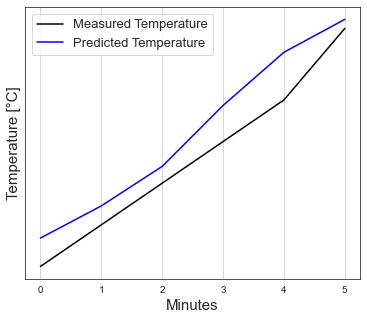

In [121]:
sequences_name = '471724_str_1'

fig, (ax1) = plt.subplots(1, figsize=(6, 5),  sharex=True, sharey=True)
ax1.plot(real_values[sequences_name][:,:1], color='black', label='Measured Temperature')
ax1.plot(prediction[sequences_name][:,:1], color='blue', label='Predicted Temperature')
ax1.legend(loc='best')
ax1.grid()
ax1.set_xlabel('Minutes', fontsize=15)
ax1.set_ylabel('Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
ax1.legend(prop={'size': 13})
print('RMSE:', rmse[sequences_name] )

RMSE: 1.6746665431655459


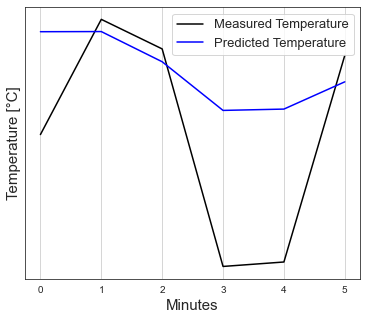

In [122]:
sequences_name = '471724_str_2'

fig, (ax1) = plt.subplots(1, figsize=(6, 5),  sharex=True, sharey=True)
ax1.plot(real_values[sequences_name][:,1:2], color='black', label='Measured Temperature')
ax1.plot(prediction[sequences_name][:,1:2], color='blue', label='Predicted Temperature')
ax1.legend(loc='best')
ax1.grid()
ax1.set_xlabel('Minutes', fontsize=15)
ax1.set_ylabel('Temperature [°C]',fontsize=15)
ax1.set(yticks=[]) 
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
ax1.legend(prop={'size': 13})
print('RMSE:', rmse[sequences_name] )